In [19]:
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torch.utils.data import random_split
from sklearn.model_selection import KFold
from tqdm import trange

from network import FullyConnectedNetwork
from custom_dataset import CustomDataset
from ModelTraining import ModelTraining

# Running on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
# Create Datasets for training and testing
train_dataset = CustomDataset(
    data_dir = './resource/dataset_regression.csv',
    data_mode = "train",
)

In [21]:
total_train_samples = len(train_dataset)
test_size = int(total_train_samples * 0.3)
train_size = total_train_samples - test_size

# Split the data set
train_subset, test_subset = random_split(train_dataset, [train_size, test_size])

Training on fold 1


100%|██████████| 100/100 [00:01<00:00, 98.16it/s]


Training on fold 2


100%|██████████| 100/100 [00:00<00:00, 104.06it/s]


Training on fold 3


100%|██████████| 100/100 [00:00<00:00, 100.40it/s]


Training on fold 4


100%|██████████| 100/100 [00:01<00:00, 96.25it/s]


Training on fold 5


100%|██████████| 100/100 [00:01<00:00, 99.15it/s]


Training loss: 0.1703270323947072
Validation loss: 0.1945082288980484


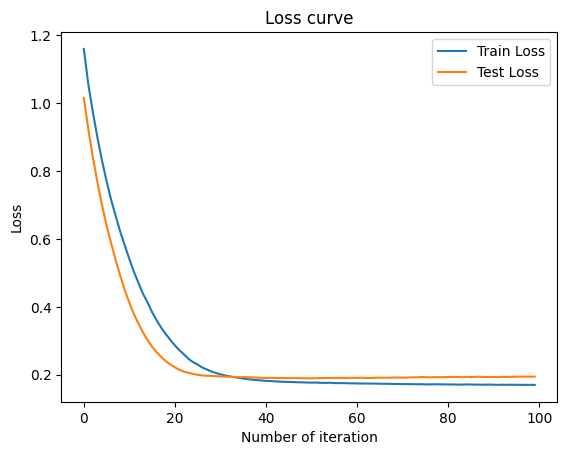

In [22]:
k_fold = 5
kfold = KFold(n_splits=k_fold)

train_loss = []
val_loss = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(train_subset)):
    # Split the current dataset for training and validation
    train_sub = Subset(train_subset, train_ids)
    val_sub = Subset(train_subset, val_ids)
    
    # Create DataLoader for training and validation
    train_loader = DataLoader(train_sub, batch_size=9, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=9, shuffle=False)
    
    # Define trainer to train the model
    trainer = ModelTraining(train_loader, len(train_sub), val_loader, len(val_sub))

    # Define and import the model
    fcn = FullyConnectedNetwork().to(device)
    trainer.set_network(fcn)

    # Define and import loss function
    criterion = torch.nn.MSELoss()
    trainer.set_criterion(criterion)
    
    # Define and import optimizer
    optimizer = torch.optim.Adam(fcn.parameters(), lr=0.005, weight_decay=1e-6)    
    trainer.set_optimizer(optimizer)

    # Train the model
    print(f"Training on fold {fold+1}")
    trainer.train(100, val=True)

    train_loss.append(trainer.get_train_loss_list())
    val_loss.append(trainer.get_val_loss_list())

# Calculate the average loss of all flows
train_loss = [sum(sublist) / len(sublist) for sublist in zip(*train_loss)]
val_loss = [sum(sublist) / len(sublist) for sublist in zip(*val_loss)]

# Print the loss of the last 5 iterations
print(f"Training loss: {sum(train_loss[-5:]) / 5}")
print(f"Validation loss: {sum(val_loss[-5:]) / 5}")

# Add training and validation loss to the graphics
plt.plot(range(100), train_loss, label = "Train Loss")
plt.plot(range(100), val_loss, label = "Test Loss")

# Show the graphics
plt.legend()
plt.title(f"Loss curve")
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.show()


100%|██████████| 100/100 [00:01<00:00, 67.22it/s]


Training loss: 0.165722286850214
Validation loss: 0.16100165471434594


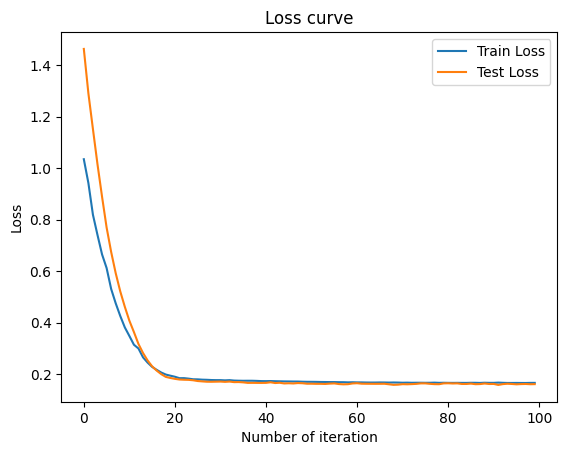

In [26]:
# Final testing
# Create DataLoader for training and validation
train_loader = DataLoader(train_subset, batch_size=9, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=9, shuffle=False)

# Define trainer to train the model
trainer = ModelTraining(train_loader, len(train_subset), test_loader, len(test_subset))

# Define and import the model
fcn = FullyConnectedNetwork().to(device)
trainer.set_network(fcn)

# Define and import loss function
criterion = torch.nn.MSELoss()
trainer.set_criterion(criterion)

# Define and import optimizer
optimizer = torch.optim.Adam(fcn.parameters(), lr=0.005, weight_decay=1e-6)    
trainer.set_optimizer(optimizer)

# Train the model
epoch_iter = 100
trainer.train(epoch_iter, val=True)

# Get the loss list
train_loss = trainer.get_train_loss_list()
val_loss = trainer.get_val_loss_list()

# Print the loss of the last 5 iterations
print(f"Training loss: {sum(train_loss[-5:]) / 5}")
print(f"Validation loss: {sum(val_loss[-5:]) / 5}")

# Add training and validation loss to the graphics
plt.plot(range(epoch_iter), train_loss, label = "Train Loss")
plt.plot(range(epoch_iter), val_loss, label = "Test Loss")

# Show the graphics
plt.legend()
plt.title(f"Loss curve")
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
# save the model
torch.save(trainer.get_model(), './model/fcn_state_dict.pth')